# Validate Dataset To Detect Anomalies

[![Jupyter Notebook](https://img.shields.io/badge/jupyter-%23FA0F00.svg?style=for-the-badge&logo=jupyter&logoColor=white)](https://github.com/openvinotoolkit/datumaro/blob/develop/notebooks/11_validate.ipynb)

In this notebook example, we are going to generate the validation report, which contains types of anomaly data regarding to [validate](https://openvinotoolkit.github.io/datumaro/latest/docs/command-reference/context_free/validate). Through this, we can identify which data was inapplicable for DL workflow because it is broken or undefined. Moreover, we detect imbalanced, out-of-distributed, or rare samples together.

## Prerequisite 
### Download COCO 2017 validation dataset 
Please refer [this notebook](https://openvinotoolkit.github.io/datumaro/latest/docs/jupyter_notebook_examples/notebooks/03_visualize.html) for preparing COCO 2017 validation dataset.

In [1]:
from datumaro.components.dataset import Dataset

path = "coco_dataset"
dataset = Dataset.import_from(path, "coco_instances")

print("Representation for sample COCO dataset")
dataset

Representation for sample COCO dataset


Dataset
	size=5000
	source_path=coco_dataset
	media_type=<class 'datumaro.components.media.Image'>
	annotated_items_count=4952
	annotations_count=78647
subsets
	val2017: # of items=5000, # of annotated items=4952, # of annotations=78647, annotation types=['mask', 'bbox', 'polygon']
infos
	categories
	label: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 

## Generate the validation report 

We first generate the validation report with given conditions. The `few_sample_thr` warns users when the number of samples per class is less than a given threshold. The `imbalance_ratio_thr` warns users when the imbalance ratio, which is calculated by dividing the number of samples corresponding to the majority class by the number of samples corresponding to the minority class, is larger than a given threshold. The `far_from_mean_thr` defines the threshold $x$ for warning annotations if it exceeds mean $\pm$  x * stddev

In [2]:
from datumaro.plugins.validators import DetectionValidator

extra_args = {
    "few_samples_thr": 100,
    "imbalance_ratio_thr": 5,
    "far_from_mean_thr": 20.0,
}

validator = DetectionValidator(**extra_args)


def validate(dataset):
    reports = validator.validate(dataset)

    print("Validation report summary:", reports["summary"])

    error_cnt = {}
    warning_cnt = {}
    for report in reports["validation_reports"]:
        if report["severity"] == "error":
            type = report["anomaly_type"]
            if error_cnt.get(type) is None:
                error_cnt[type] = 1
            else:
                error_cnt[type] += 1
        if report["severity"] == "warning":
            type = report["anomaly_type"]
            if warning_cnt.get(type) is None:
                warning_cnt[type] = 1
            else:
                warning_cnt[type] += 1
    print("The number of errors per error type: ", error_cnt)
    print("The number of warnings per warning type: ", warning_cnt)

    return reports


reports = validate(dataset)

Validation report summary: {'errors': 36782, 'warnings': 122}
The number of errors per error type:  {'UndefinedAttribute': 36781, 'NegativeLength': 1}
The number of warnings per warning type:  {'MissingAnnotation': 48, 'FewSamplesInLabel': 9, 'ImbalancedLabels': 1, 'ImbalancedDistInLabel': 59, 'FarFromLabelMean': 5}


We here checked that most of errors are coming from the `UnderfinedAttribute`. This is because, the attribute of MS-COCO dataset, i.e., is_crowd, is not defined in metadata. We are going to provide the validation description and the visualization of `NegativeLength` sample below.

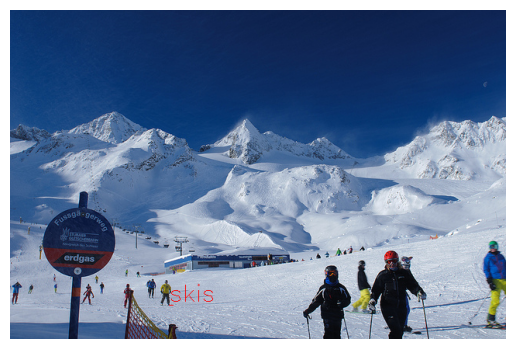

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from datumaro.components.annotation import AnnotationType, LabelCategories

label_categories = dataset.categories().get(AnnotationType.label, LabelCategories())


def visualize_label_id(item, label_id=None):
    img = item.media.data.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for ann in item.annotations:
        if not label_id:
            continue
        if ann.id == label_id:
            x, y, w, h = ann.get_bbox()
            label_name = label_categories[ann.label].name
            x1, y1, x2, y2 = int(x), int(y), int(x + w), int(y + h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
            cv2.putText(img, label_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))

    plt.imshow(img)
    plt.axis("off")
    plt.show()


for report in reports["validation_reports"]:
    if report["anomaly_type"] == "NegativeLength":
        item = dataset.get(report["item_id"], report["subset"])
        label_id = [int(s) for s in str.split(report["description"], "'") if s.isdigit()][0]
        visualize_label_id(item, label_id)

## Manual correction of validation errors

From now on, we are going to fix the dataset from reported errors. For the `UnderfinedAttribute`, we will update the label information of the dataset with the attributes as below. Meanwhile, we will remove the `NegativeLength` by rejecting the specific label from annotations in the sample. 

In [4]:
from datumaro.components.annotation import AnnotationType, LabelCategories

label_categories = dataset.categories().get(AnnotationType.label, LabelCategories())

for report in reports["validation_reports"]:
    if report["anomaly_type"] == "UndefinedAttribute":
        item = dataset.get(report["item_id"], report["subset"])
        for ann in item.annotations:
            for k in ann.attributes.keys():
                label_categories[ann.label].attributes.add(k)

    if report["anomaly_type"] == "NegativeLength":
        item = dataset.get(report["item_id"], report["subset"])
        print(report["description"])
        label_id = [int(s) for s in str.split(report["description"], "'") if s.isdigit()][0]
        neg_len_anns = []
        for ann in item.annotations:
            if ann.id == label_id:
                neg_len_anns.append(ann)
        for ann in neg_len_anns:
            item.annotations.remove(ann)

reports = validate(dataset)

Annotation '2202383' in the item should have a positive value of 'bounding box height' but got '0.86'.
Validation report summary: {'errors': 0, 'warnings': 347}
The number of errors per error type:  {}
The number of warnings per warning type:  {'MissingAnnotation': 48, 'FewSamplesInLabel': 9, 'ImbalancedLabels': 1, 'FewSamplesInAttribute': 50, 'ImbalancedAttribute': 42, 'OnlyOneAttributeValue': 38, 'ImbalancedDistInLabel': 59, 'ImbalancedDistInAttribute': 93, 'FarFromLabelMean': 5, 'FarFromAttrMean': 2}


## Inspection of warnings

Although the severe errors have been fixed above, it is still important to address the warnings because they may contain potential annotation errors. Datumaro provides a report to users by checking if the labels in the dataset are imbalanced through `ImbalancedLabels` or if certain annotations deviate significantly from the distribution `FarFromLabelMean`. It is crucial to review and address these warnings to ensure the quality and accuracy of the dataset. We are going to start from the label distribution of MS-COCO validation dataset.

There is an imbalance in the label distribution.


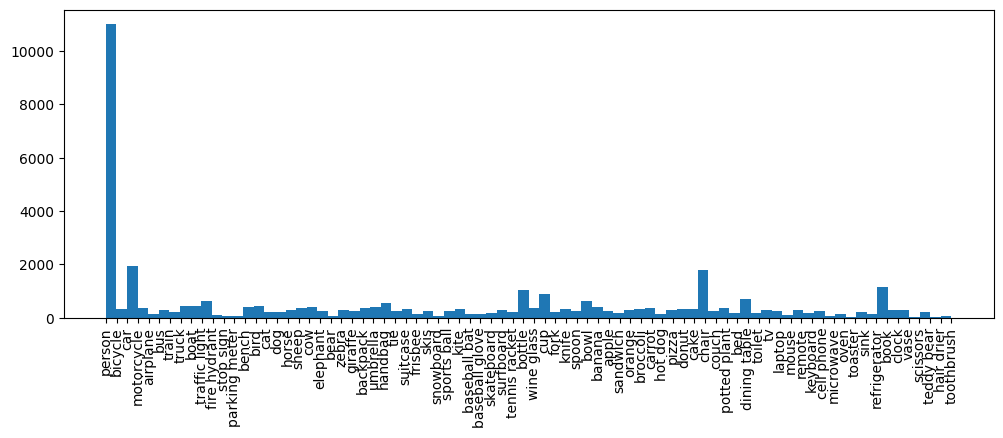

In [5]:
for report in reports["validation_reports"]:
    if report["anomaly_type"] == "ImbalancedLabels":
        print(report["description"])

stats = reports["statistics"]

label_stats = stats["label_distribution"]["defined_labels"]
label_name, label_counts = zip(*[(k, v) for k, v in label_stats.items()])

plt.figure(figsize=(12, 4))
plt.hist(label_name, weights=label_counts, bins=len(label_name))
plt.xticks(rotation="vertical")
plt.show()

We will then visualize the `MissingAnnotation` samples below.

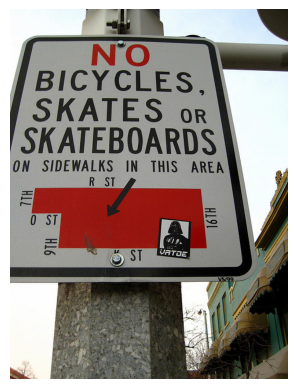

In [6]:
missing_annotations = []
for report in reports["validation_reports"]:
    if report["anomaly_type"] == "MissingAnnotation":
        missing_annotations.append(dataset.get(report["item_id"], report["subset"]))

visualize_label_id(missing_annotations[0])

We now show the samples with the `FarFromLabelMean` warning.

Annotation '900100474028' in the item has a value of 'bounding box ratio(w/h)' that is too far from the label average. (mean of 'person' label: 0.7, got '16.77').


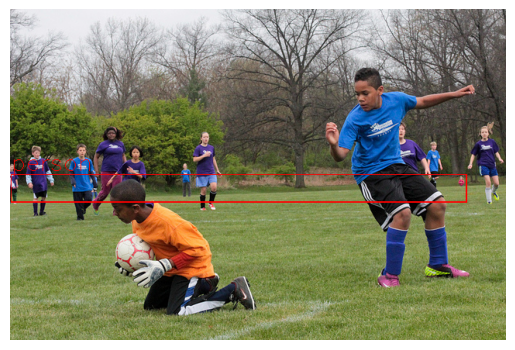

Annotation '900100325031' in the item has a value of 'bounding box ratio(w/h)' that is too far from the label average. (mean of 'person' label: 0.7, got '19.72').


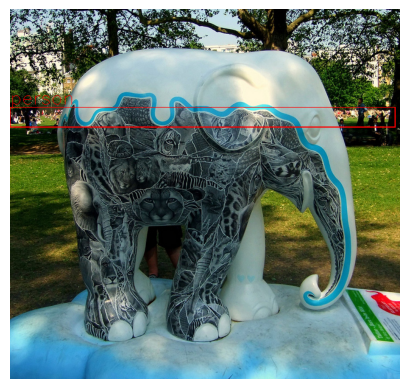

Annotation '900100332351' in the item has a value of 'bounding box ratio(w/h)' that is too far from the label average. (mean of 'person' label: 0.7, got '23.45').


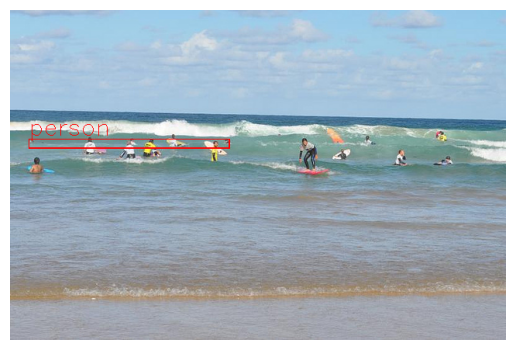

Annotation '1330416' in the item has a value of 'bounding box ratio(w/h)' that is too far from the label average. (mean of 'person' label: 0.7, got '18.76').


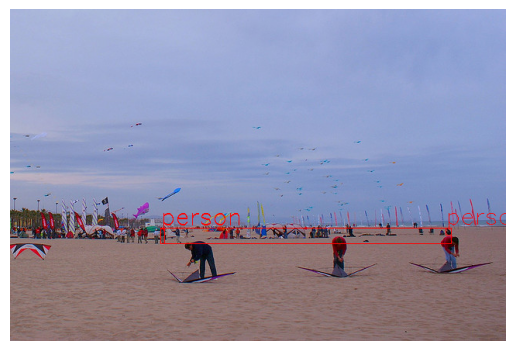

Annotation '900300121242' in the item has a value of 'bounding box ratio(w/h)' that is too far from the label average. (mean of 'car' label: 1.67, got '29.29').


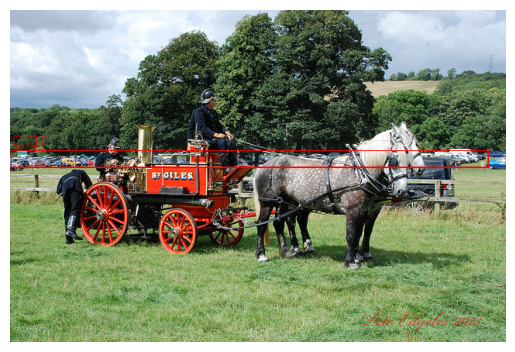

In [7]:
for report in reports["validation_reports"]:
    if report["anomaly_type"] == "FarFromLabelMean":
        print(report["description"])
        item = dataset.get(report["item_id"], report["subset"])
        label_id = [int(s) for s in str.split(report["description"], "'") if s.isdigit()][0]
        visualize_label_id(item, label_id)

Specifically, we can draw the detailed statistics with 6 types of properties, i.e., width, height, area, ratio, short, and long, per each label.

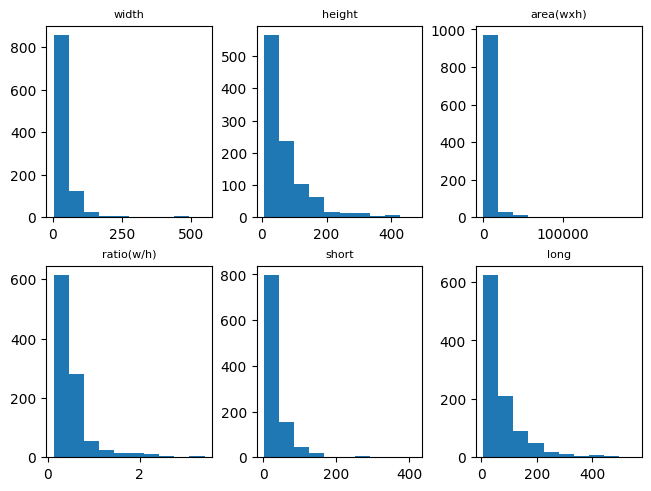

In [8]:
bottle_bbox_dist = stats["point_distribution_in_label"]["bottle"]

fig, axs = plt.subplots(2, 3, layout="constrained")

properties = list(bottle_bbox_dist.keys())
for prop, ax in zip(properties, axs.flat):
    bins = bottle_bbox_dist[prop]["histogram"]["bins"]
    counts = bottle_bbox_dist[prop]["histogram"]["counts"]
    ax.hist(bins[:-1], bins, weights=counts)
    ax.set_title(prop, fontsize=8)